# Exploration 11. 어제 오른 내 주식, 과연 내일은?
본 과제는 ARIMA(AutoRegressive Integrated Moving Average) 모델을 이용한 시계열 데이터 예측 방식을 이용하여 실제 주식의 값을 예측하는 과제이다.

## 루브릭 평가 기준
1. 시계열의 안정성이 충분히 확인되었는가?<br>
   플로팅과 adfuller 메소드가 모두 적절히 사용되었음<br>
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?<br>
   p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨<br>
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?<br>
   3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨<br>
   
## ARIMA(AutoRegressive Integrated Moving Average) 모델
* AR(자기회귀, Autoregressive)
  * 시계열의 Residual에 해당하는 부분을 모델링
  * 변수의 과거 값의 선형 조합을 이용하여 관심 있는 변수를 예측
  * 자기 자신에 대한 변수의 회귀
  * 다양한 종류의 서로 다른 시계열 패턴을 매우 유연하게 다룰 수 있음
* MA(이동평균, Moving Average)
  * 시계열의 Trend에 해당하는 부분을 모델링
  * 회귀처럼 보이는 모델에서 과거 예측 오차(forecast error)을 이용
  * 미래의 값을 예측할 때 사용
* I(차분 누적, Integration)
  * 시계열의 Seasonality에 해당하는 부분을 모델링
  * 이전 데이터와 d차 차분의 누적(integration)의 합
* ARIMA 모델의 모수
  * p : 자기회귀 모형(AR)의 시차
  * d : 차분 누적(I) 횟수
  * q : 이동평균 모형(MA)의 시차
* ARIMA의 적절한 모수 p, d, q를 선택하는 방법
  * ACF(Autocorrelation Function)
    * 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    * 주어진 시계열의 현재 값이 과거의 값과 어떻게 상관되는지 설명
    * ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
  * PACF(Partial Autocorrelation Function)
    * 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
    * k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도

## 1. 시계열 데이터 준비
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음
* 본 과제에서는 하루의 장이 마감하였을 때의 가격인 종가(Close)만 사용함

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

* 시각화를 통해 안정성(Stationarity) 여부 확인

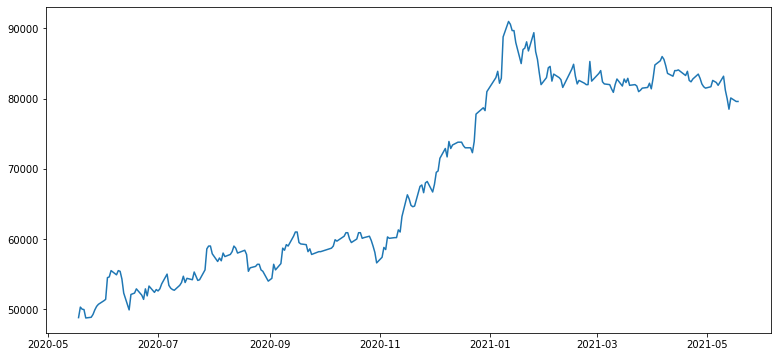

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 2. 각종 전처리 수행
* 결측치 처리

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


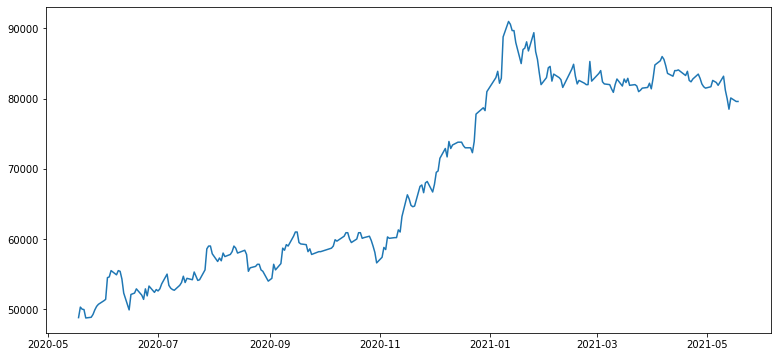

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

* 로그 변환

In [5]:
# 로그 변환
ts_log = np.log(ts)

## 3. 시계열 안정성 분석
* 정성적 그래프 분석
  * 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화
  * 현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화 해 봄으로서 경향성을 확인

In [6]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


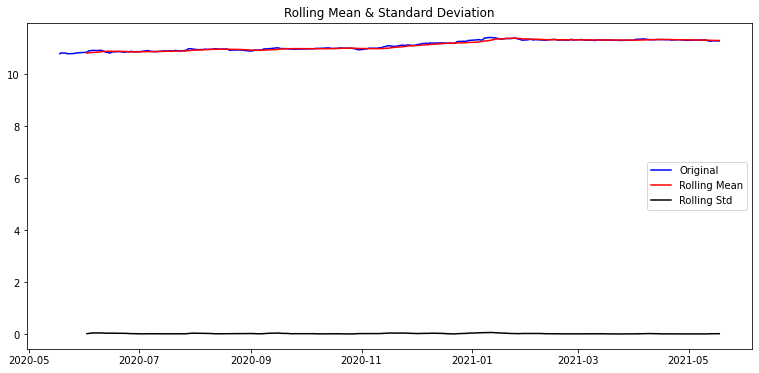

In [7]:
plot_rolling_statistics(ts_log, window=12)

* 정량적 Augmented Dicky-Fuller Test
  1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
  2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우
  3. 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택

In [8]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


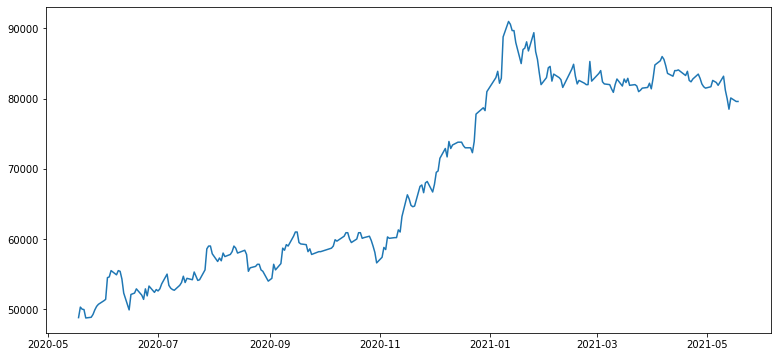

In [10]:
# 로그함수 변환
ts_log = np.log(ts)
plt.plot(ts)

In [11]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


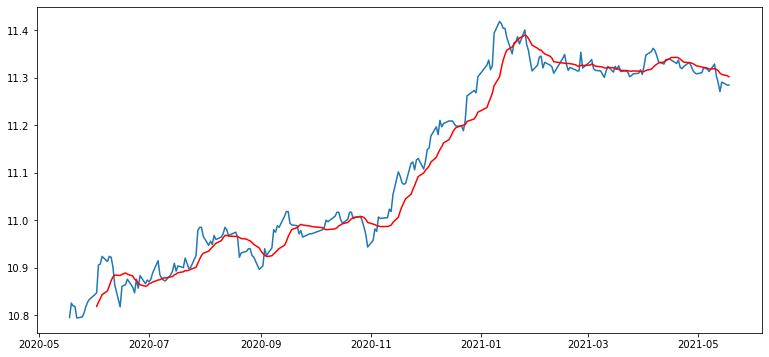

In [12]:
# Moving average 제거 : 추세(Trend) 상쇄

moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [14]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

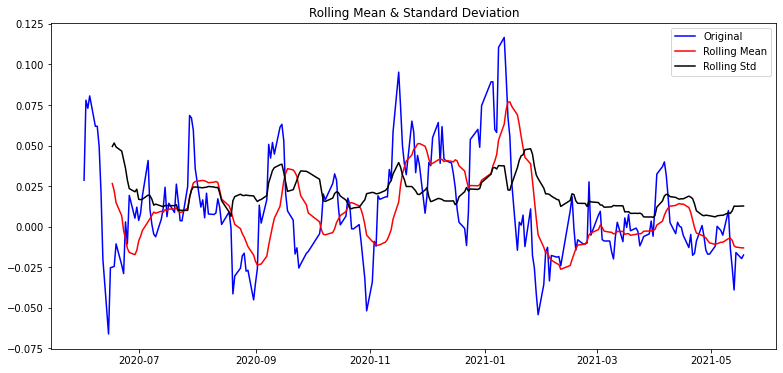

In [15]:
# 앞 단계에서 정의했던 메서드들을 활용하여 ts_log_moving_log를 정성, 정량적으로 분석
plot_rolling_statistics(ts_log_moving_avg)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


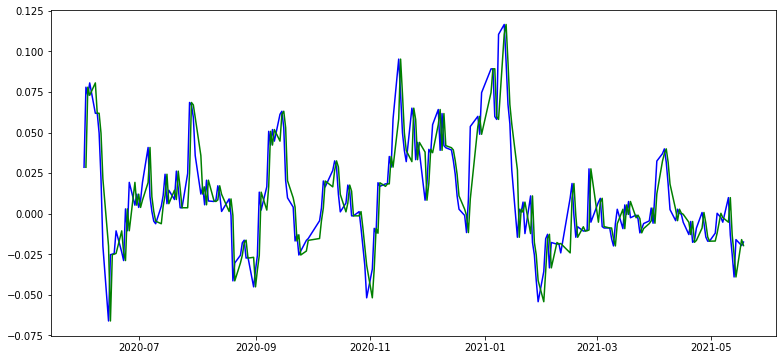

In [17]:
# Shift된 시계열과 원본 시계열에 대한 비교 그래프 작성
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

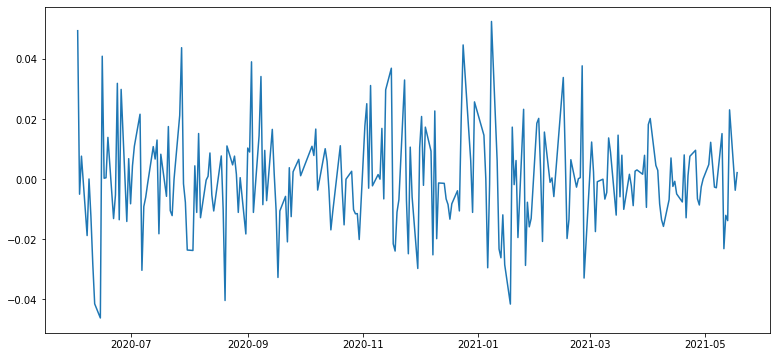

In [18]:
# 원본 시계열에서 Shift한 시계열을 뺸 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

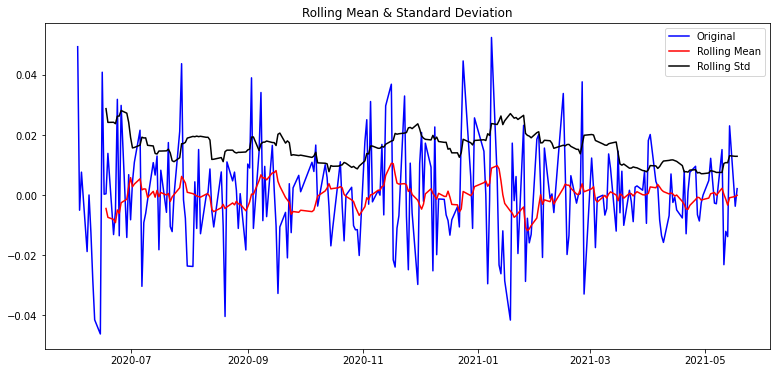

In [19]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 확인
plot_rolling_statistics(ts_log_moving_avg_diff)

In [20]:
# 차분의 효과를 확인하기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


* 시계열 분해(Time Series Decomposition)

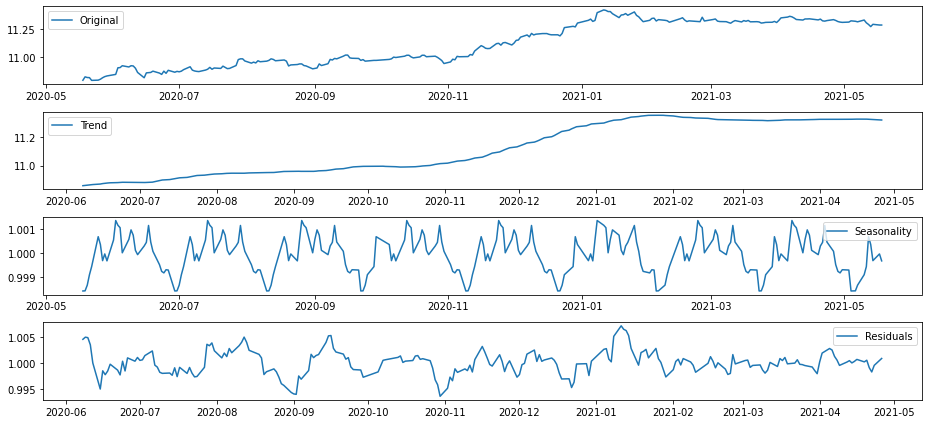

In [21]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* Residual 안정성 확인

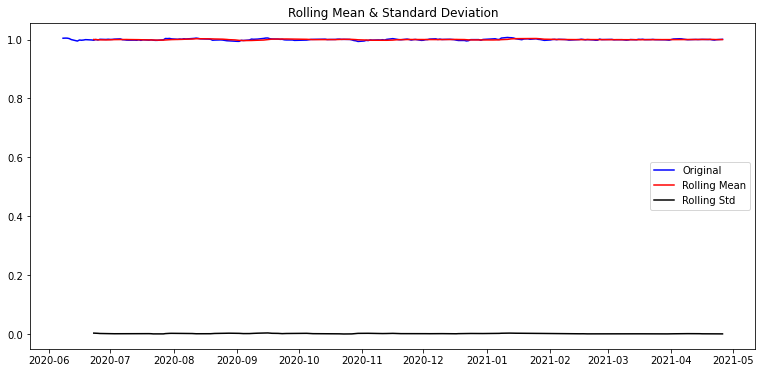

In [22]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [23]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리


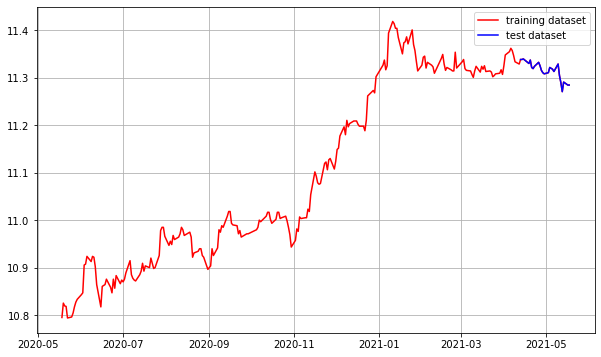

In [24]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


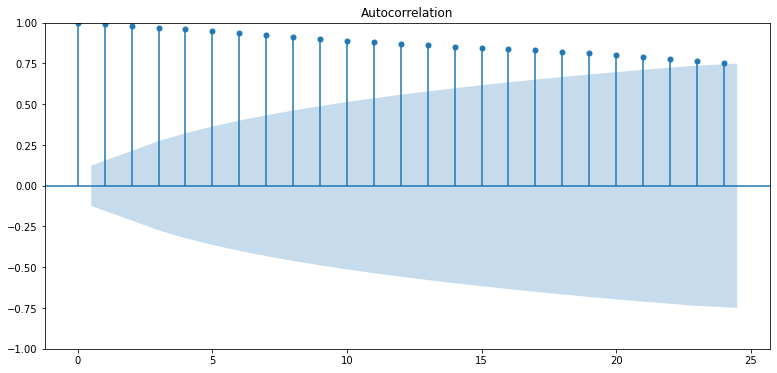

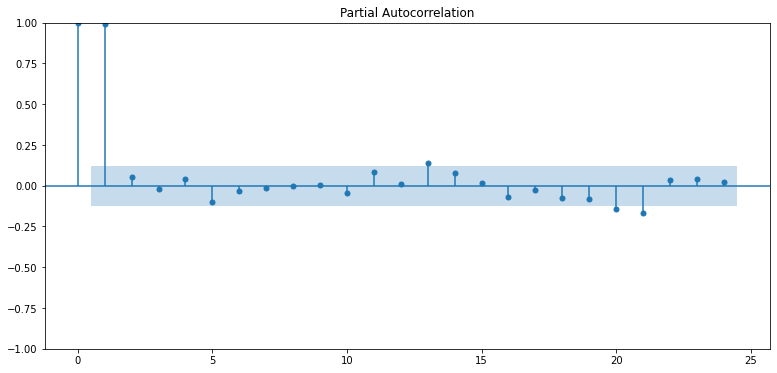

In [25]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

* 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


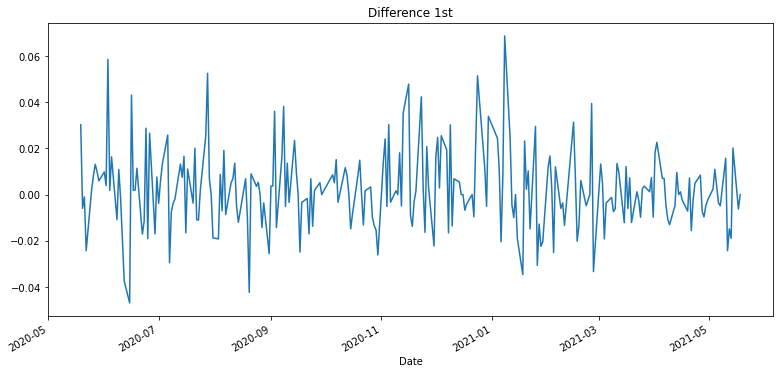

In [28]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## 6. ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련


In [29]:
# 데이터셋의 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


In [30]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(24, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(24, 1, 0)   Log Likelihood                 591.676
Date:                Thu, 10 Feb 2022   AIC                          -1133.353
Time:                        11:02:42   BIC                          -1048.062
Sample:                             0   HQIC                         -1098.925
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0417      0.071      0.586      0.558      -0.098       0.181
ar.L2         -0.0169      0.081     -0.209      0.835      -0.175       0.141
ar.L3         -0.0499      0.084     -0.594      0.5

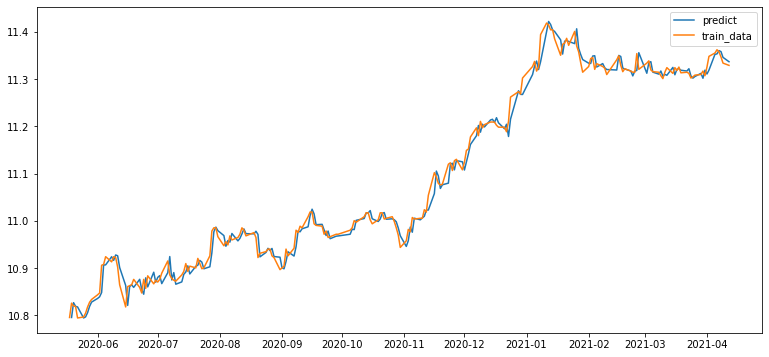

In [31]:
# ARIMA 모델 훈련 결과 시각화
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

* 모델 테스트 및 플로팅

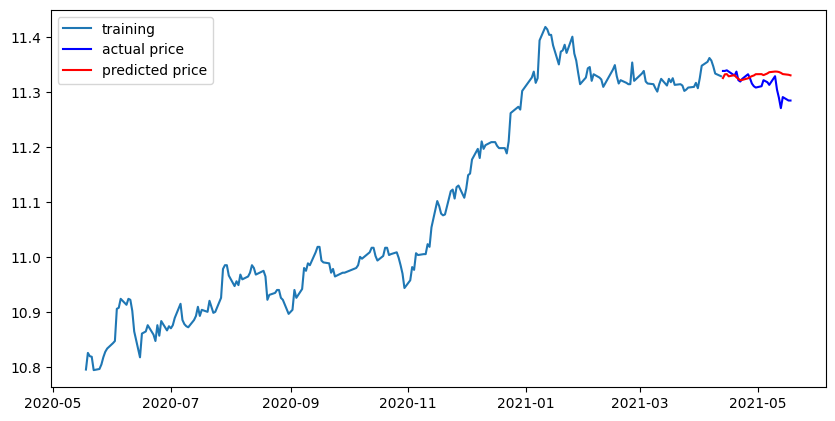

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
model = ARIMA(train_data, order=(24, 1, 0))  
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

* 최종 예측 모델 정확도 측정(MAPE)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4423019.098772124
MAE:  1565.811289549159
RMSE:  2103.0975010141883
MAPE: 1.94%


## 7-1. 다른 주식 종목 예측 해 보기(스타벅스)

In [34]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SBUX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    105.870003
2021-02-11    105.860001
2021-02-12    105.300003
2021-02-16    106.150002
2021-02-17    104.440002
Name: Close, dtype: float64

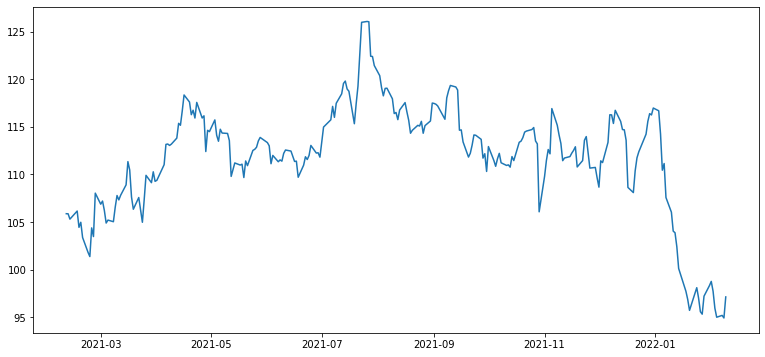

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [36]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


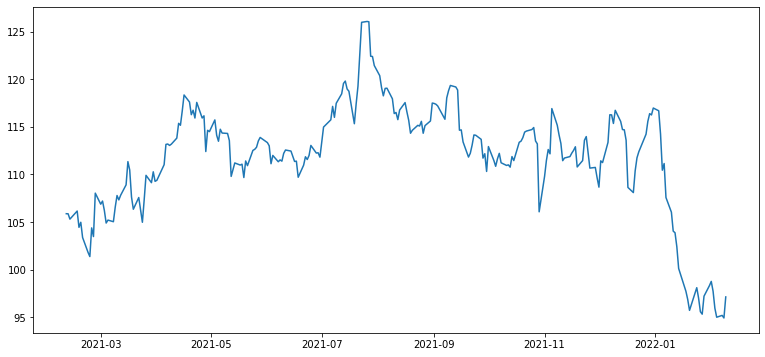

In [37]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

In [38]:
# 로그 변환
ts_log = np.log(ts)

In [39]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


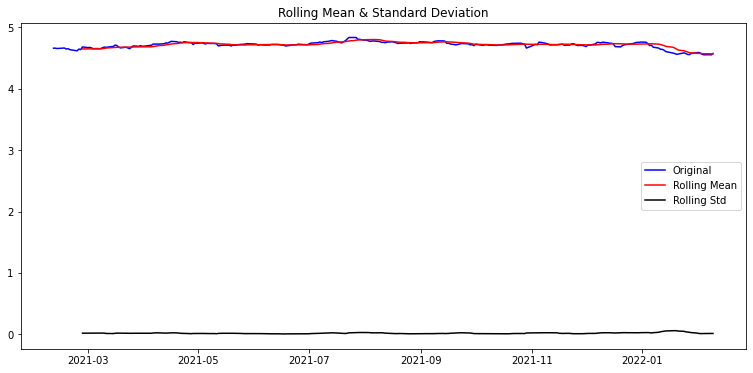

In [40]:
plot_rolling_statistics(ts_log, window=12)

In [41]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [42]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.325082
p-value                          0.617621
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


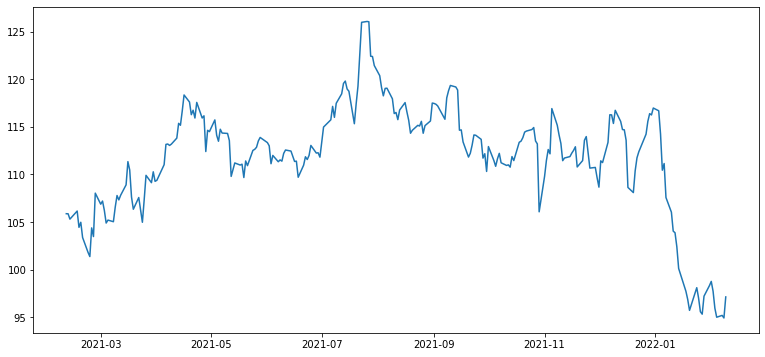

In [43]:
# 로그함수 변환
ts_log = np.log(ts)
plt.plot(ts)

In [44]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.325082
p-value                          0.617621
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


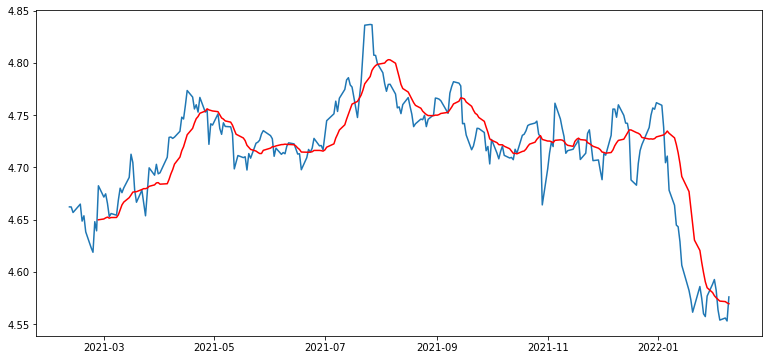

In [45]:
# Moving average 제거 : 추세(Trend) 상쇄

moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [46]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26    0.032558
2021-03-01    0.020979
2021-03-02    0.023014
2021-03-03    0.013105
Name: Close, dtype: float64

In [47]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-02-26    0.032558
2021-03-01    0.020979
2021-03-02    0.023014
2021-03-03    0.013105
2021-03-04    0.001500
2021-03-05    0.003847
2021-03-08    0.002182
2021-03-09    0.014025
2021-03-10    0.020754
2021-03-11    0.011724
2021-03-12    0.013585
2021-03-15    0.019382
2021-03-16    0.039026
2021-03-17    0.028337
2021-03-18    0.001965
Name: Close, dtype: float64

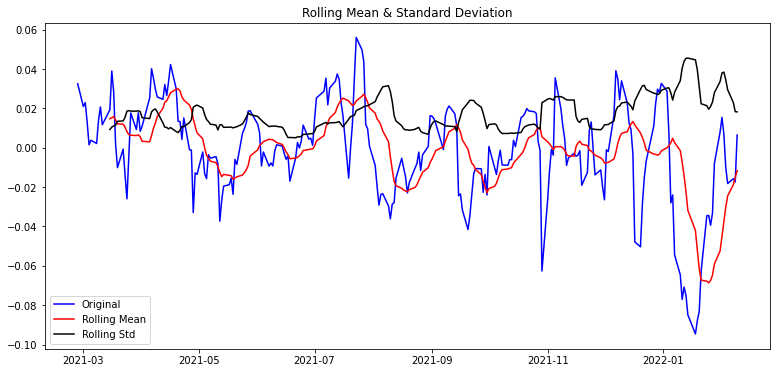

In [48]:
# 앞 단계에서 정의했던 메서드들을 활용하여 ts_log_moving_log를 정성, 정량적으로 분석
plot_rolling_statistics(ts_log_moving_avg)

In [49]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.974624
p-value                          0.000025
#Lags Used                       2.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


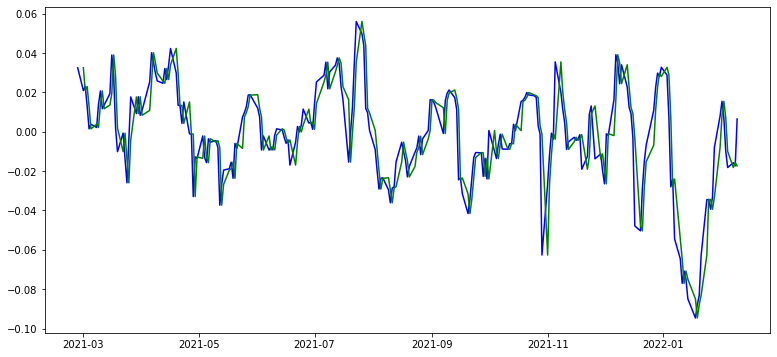

In [50]:
# Shift된 시계열과 원본 시계열에 대한 비교 그래프 작성
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

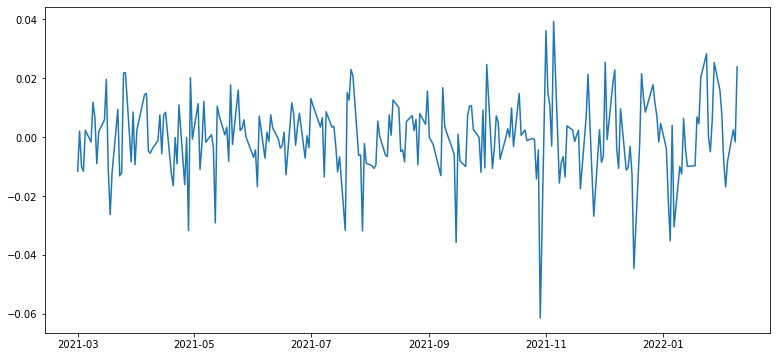

In [51]:
# 원본 시계열에서 Shift한 시계열을 뺸 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

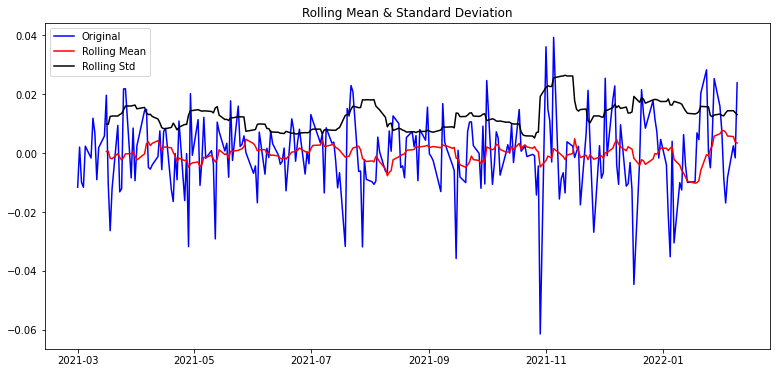

In [52]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 확인
plot_rolling_statistics(ts_log_moving_avg_diff)

In [53]:
# 차분의 효과를 확인하기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.970571e+00
p-value                        8.686465e-10
#Lags Used                     9.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


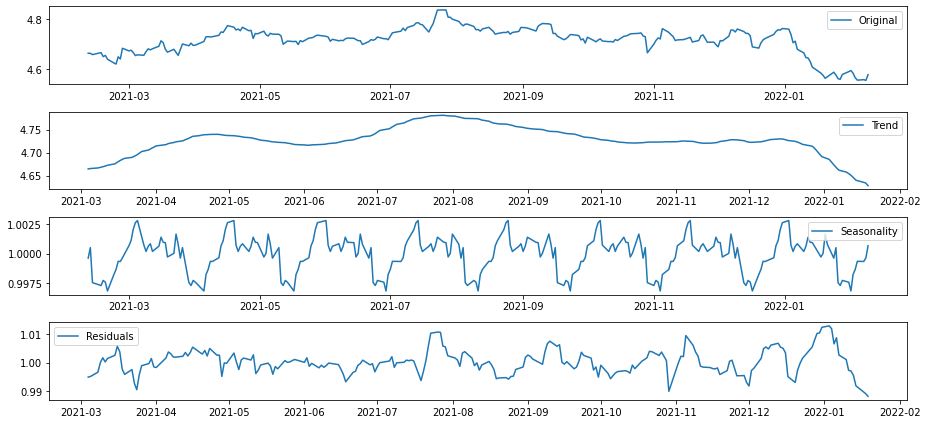

In [54]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

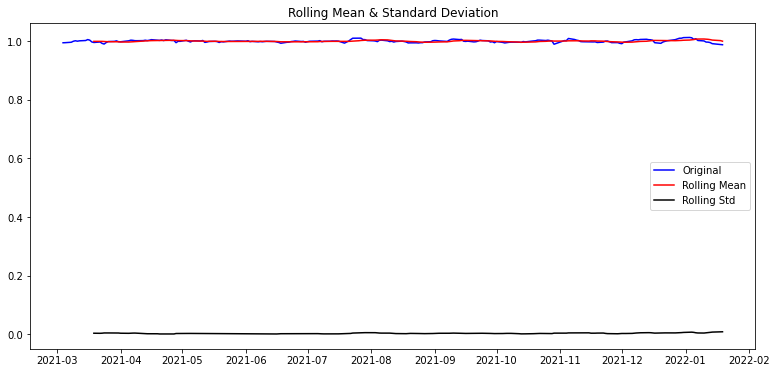

In [55]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [56]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.450555
p-value                          0.000003
#Lags Used                       2.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


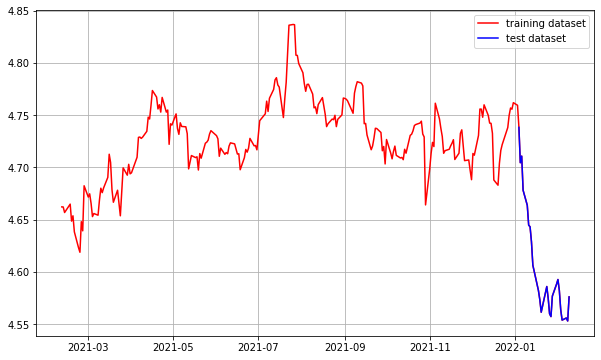

In [57]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

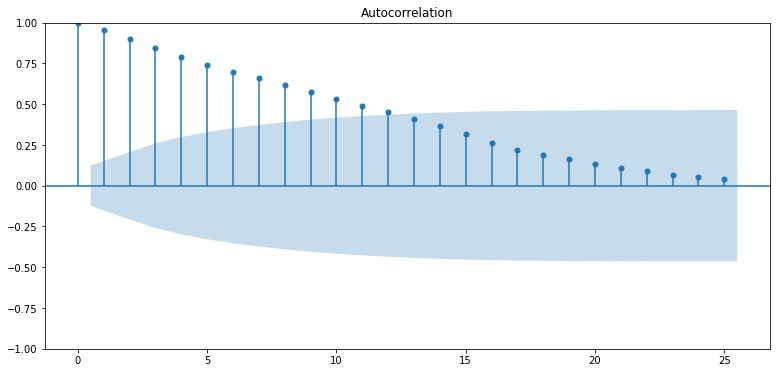

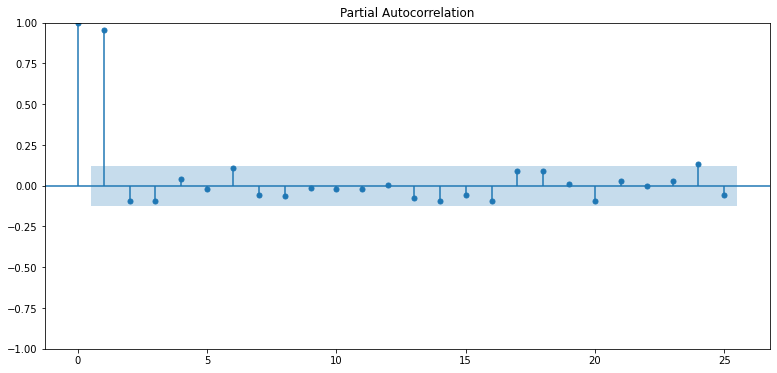

In [58]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.534366e+01
p-value                        3.801431e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


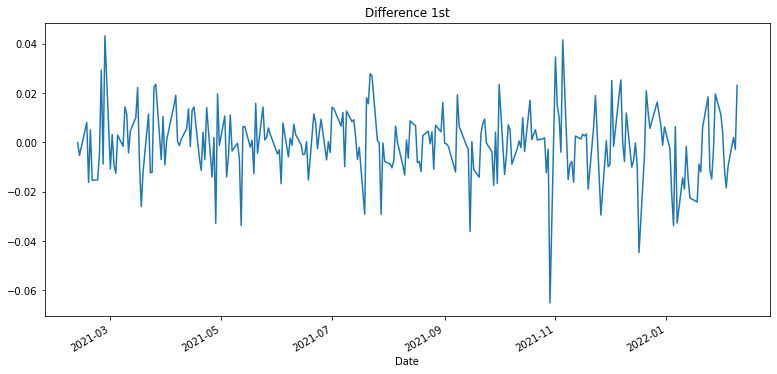

In [59]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [60]:
# 데이터셋의 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    4.662212
2021-02-11    4.662117
Name: Close, dtype: float64
(227,)
(26,)


In [89]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 3, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 3, 1)   Log Likelihood                 562.377
Date:                Thu, 10 Feb 2022   AIC                          -1120.754
Time:                        11:09:05   BIC                          -1113.931
Sample:                             0   HQIC                         -1118.000
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994      1.352     -0.739      0.460      -3.649       1.650
sigma2         0.0004      0.001      0.733      0.463      -0.001       0.001
Ljung-Box (L1) (Q):                  68.39   Jarque-

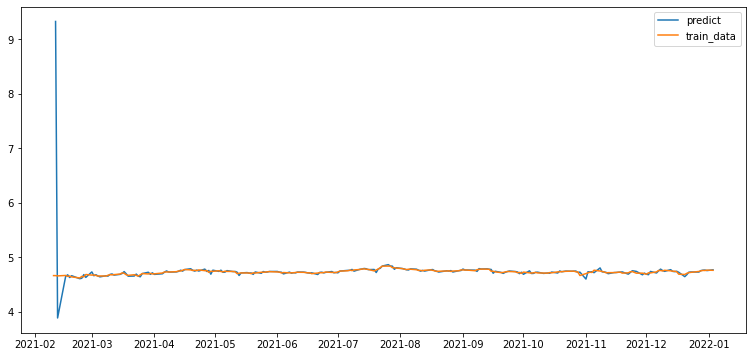

In [90]:
# ARIMA 모델 훈련 결과 시각화
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

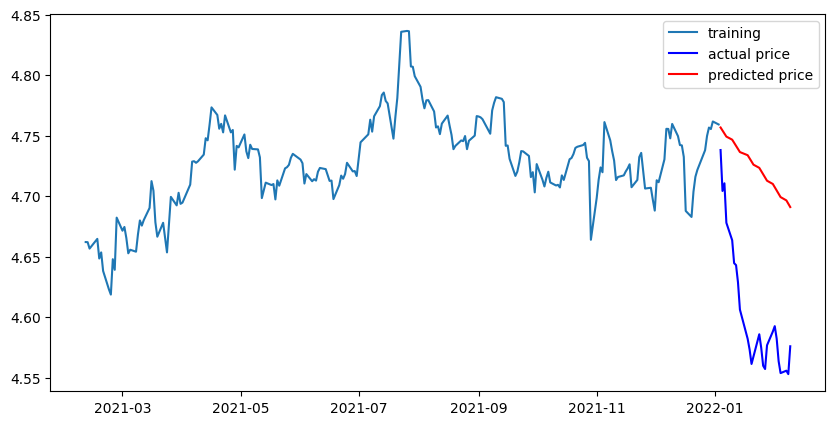

In [91]:
# Forecast : 결과가 fc에 담깁니다. 
model = ARIMA(train_data, order=(0, 3, 1))  
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [92]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  173.61915003609542
MAE:  12.601340327100903
RMSE:  13.176461969591664
MAPE: 12.81%


## 7-2. 다른 주식 종목 예측 해 보기(애플)

In [93]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64

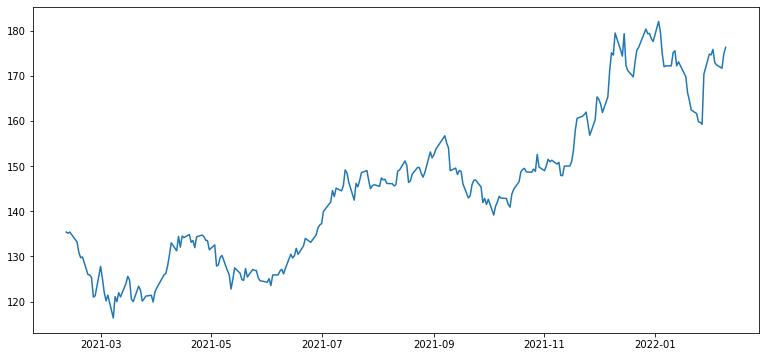

In [94]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [95]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


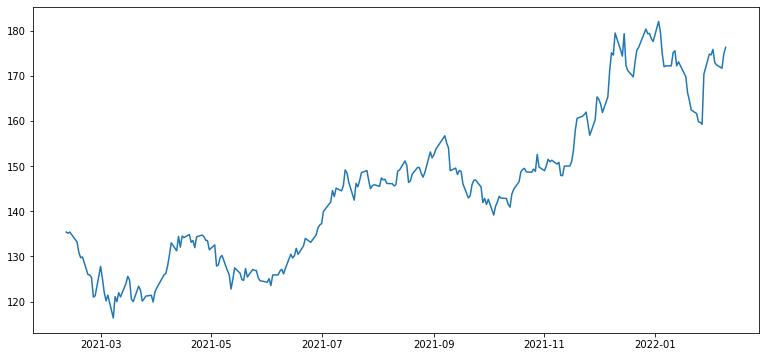

In [96]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

In [97]:
# 로그 변환
ts_log = np.log(ts)

In [98]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


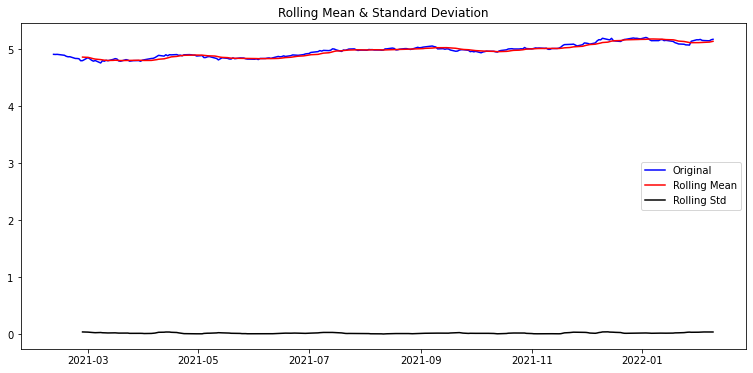

In [99]:
plot_rolling_statistics(ts_log, window=12)

In [100]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [101]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


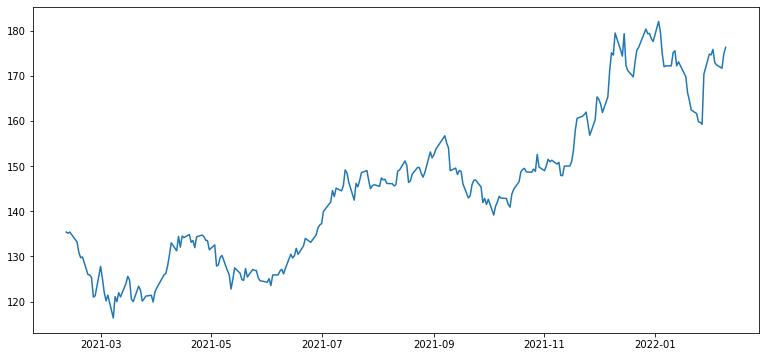

In [102]:
# 로그함수 변환
ts_log = np.log(ts)
plt.plot(ts)

In [103]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


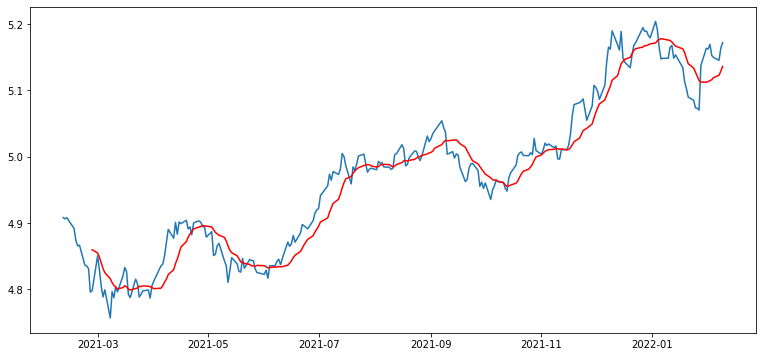

In [104]:
# Moving average 제거 : 추세(Trend) 상쇄

moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [105]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26   -0.061747
2021-03-01   -0.004481
2021-03-02   -0.019182
2021-03-03   -0.035318
Name: Close, dtype: float64

In [106]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-02-26   -0.061747
2021-03-01   -0.004481
2021-03-02   -0.019182
2021-03-03   -0.035318
2021-03-04   -0.042656
2021-03-05   -0.025748
2021-03-08   -0.059264
2021-03-09   -0.013585
2021-03-10   -0.018715
2021-03-11    0.000276
2021-03-12   -0.004456
2021-03-15    0.017666
2021-03-16    0.027418
2021-03-17    0.022946
2021-03-18   -0.008433
Name: Close, dtype: float64

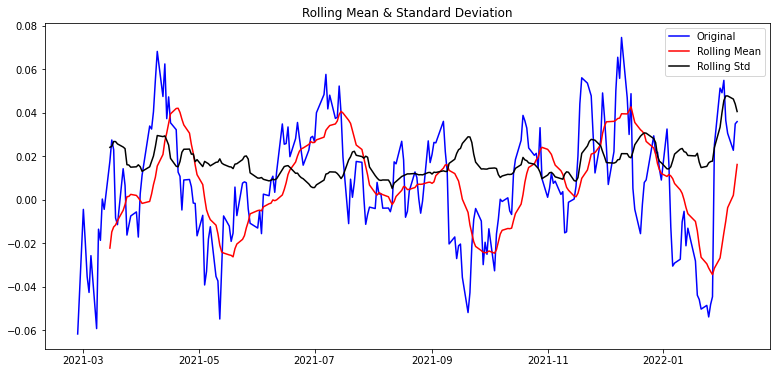

In [107]:
# 앞 단계에서 정의했던 메서드들을 활용하여 ts_log_moving_log를 정성, 정량적으로 분석
plot_rolling_statistics(ts_log_moving_avg)

In [108]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.783879
p-value                          0.000058
#Lags Used                       0.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


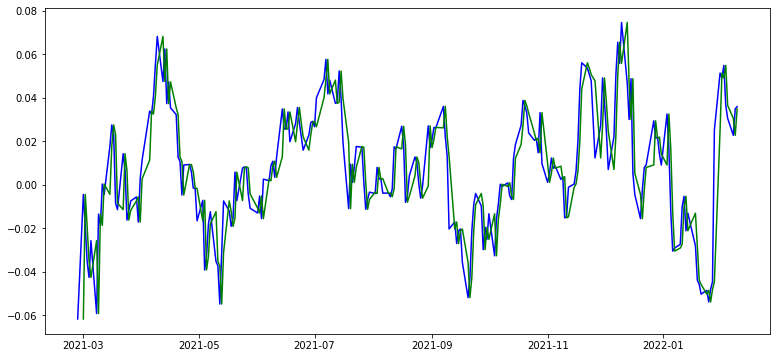

In [109]:
# Shift된 시계열과 원본 시계열에 대한 비교 그래프 작성
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

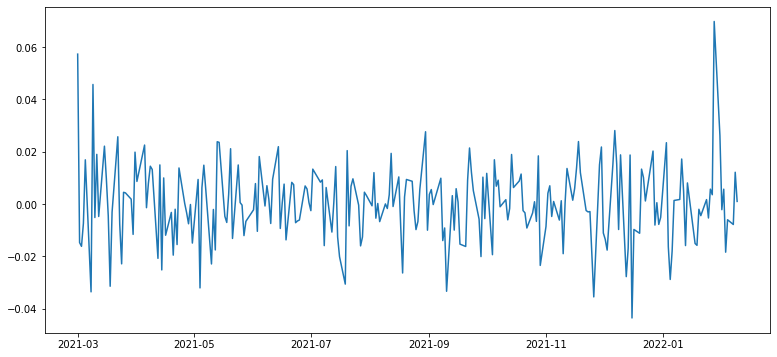

In [110]:
# 원본 시계열에서 Shift한 시계열을 뺸 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

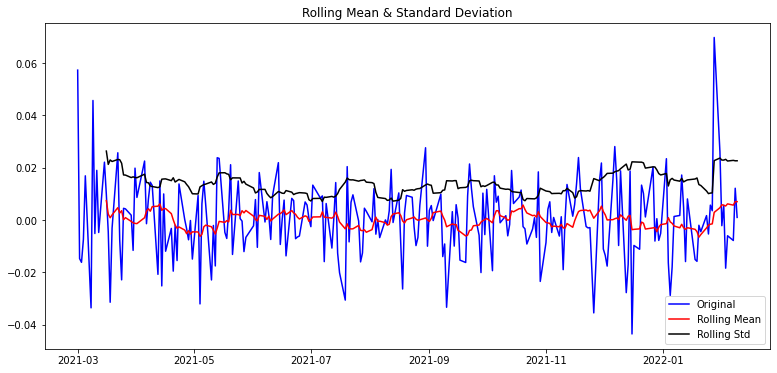

In [111]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 확인
plot_rolling_statistics(ts_log_moving_avg_diff)

In [112]:
# 차분의 효과를 확인하기 위해  Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.674470e+01
p-value                        1.349209e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


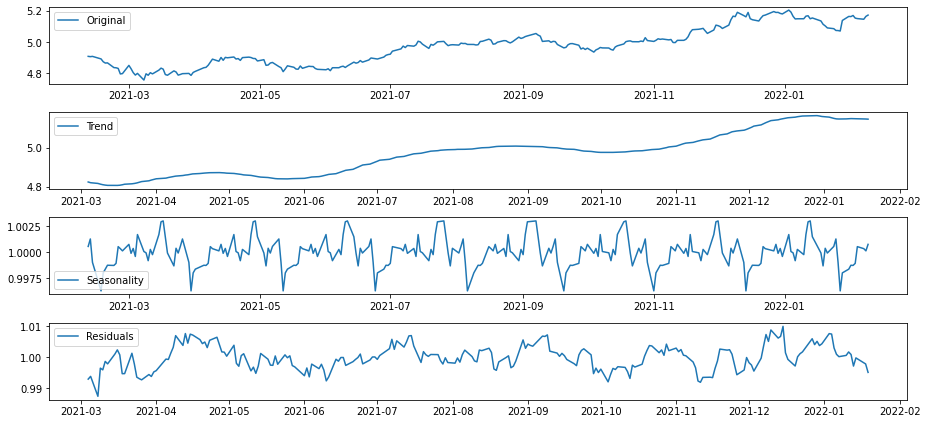

In [113]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

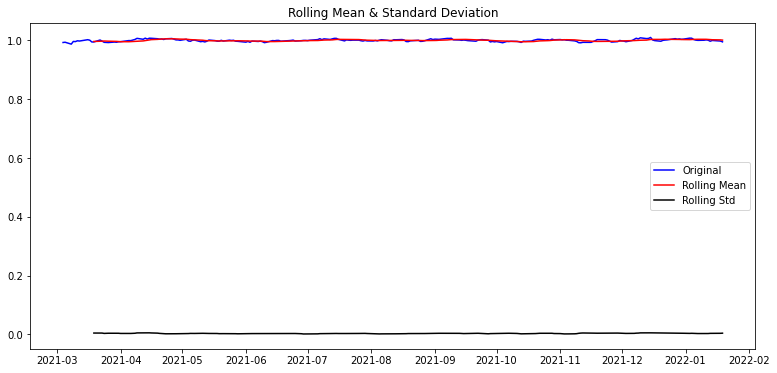

In [114]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [115]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


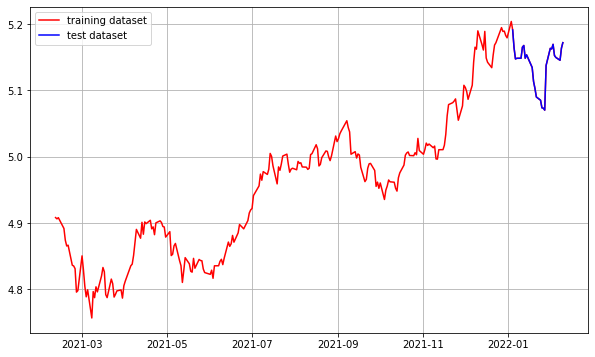

In [116]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

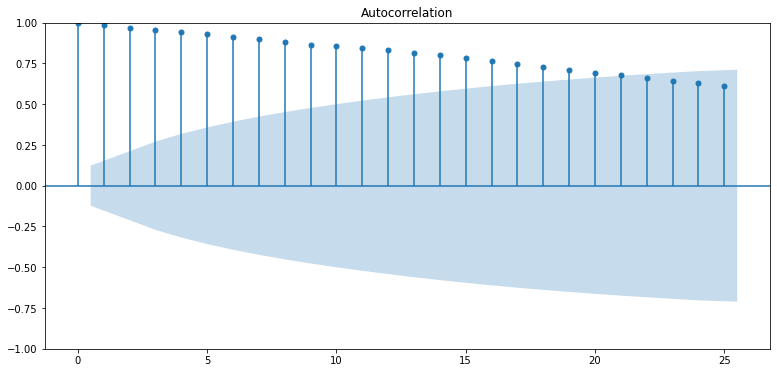

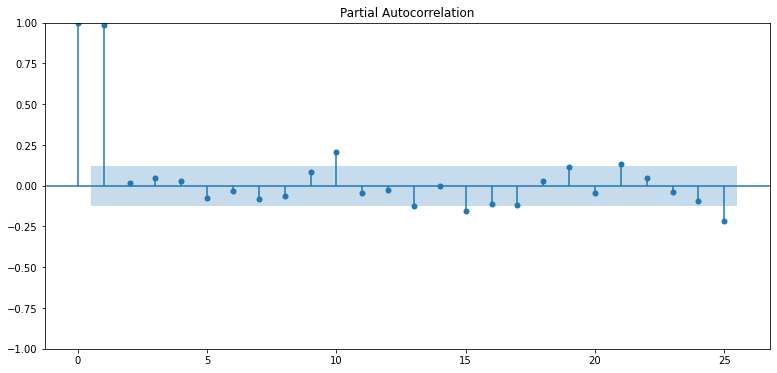

In [117]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


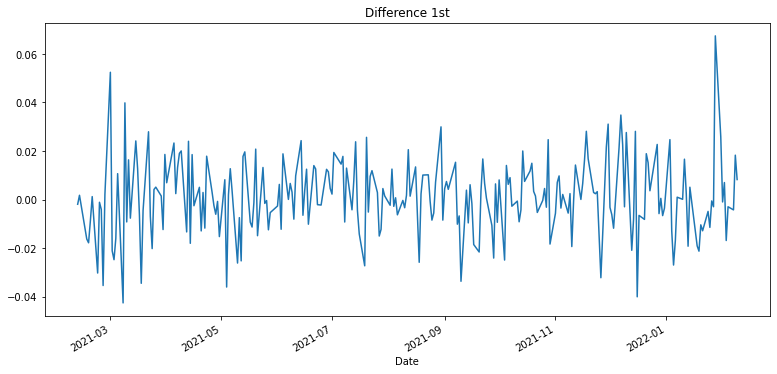

In [118]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


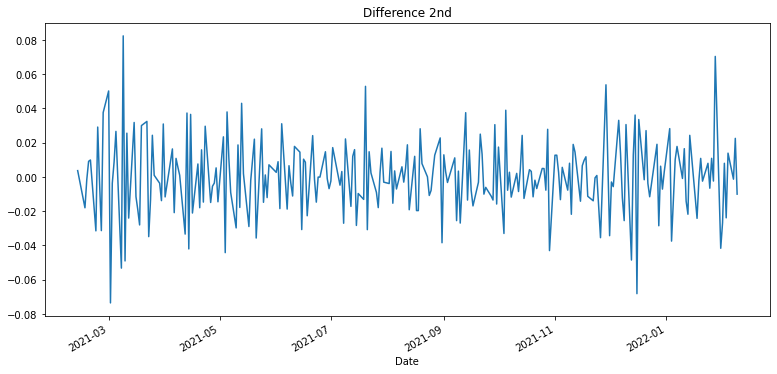

In [119]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [120]:
# 데이터셋의 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    4.908159
2021-02-11    4.906237
Name: Close, dtype: float64
(227,)
(26,)


In [124]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(10, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(10, 1, 1)   Log Likelihood                 631.156
Date:                Thu, 10 Feb 2022   AIC                          -1238.312
Time:                        11:12:28   BIC                          -1197.265
Sample:                             0   HQIC                         -1221.747
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0055      1.123      0.005      0.996      -2.196       2.207
ar.L2         -0.0270      0.103     -0.263      0.792      -0.228       0.174
ar.L3         -0.0600      0.077     -0.775      0.4

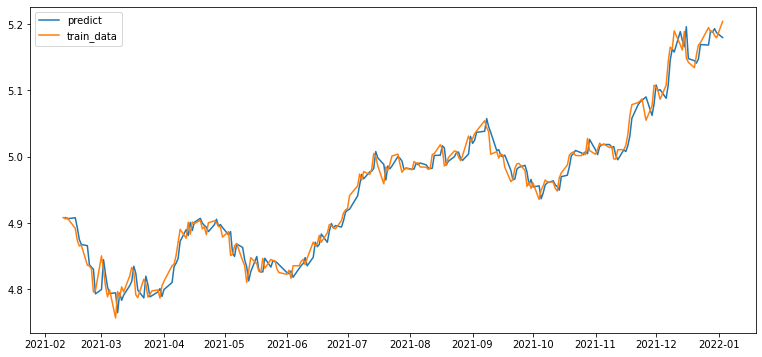

In [125]:
# ARIMA 모델 훈련 결과 시각화
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

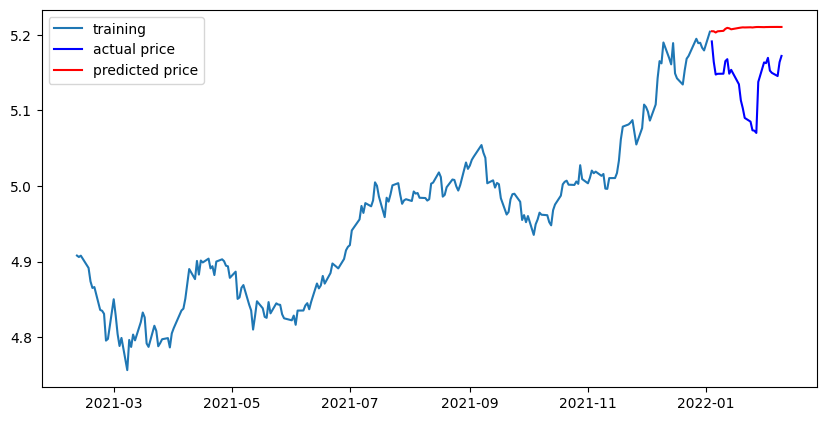

In [126]:
# Forecast : 결과가 fc에 담깁니다. 
model = ARIMA(train_data, order=(10, 1, 1))  
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [127]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  186.58256135602264
MAE:  12.334083641506952
RMSE:  13.659522735294328
MAPE: 7.36%


## 7-3. 다른 주식 종목 예측 해 보기(테슬라)

In [128]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    804.820007
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
2021-02-17    798.150024
Name: Close, dtype: float64

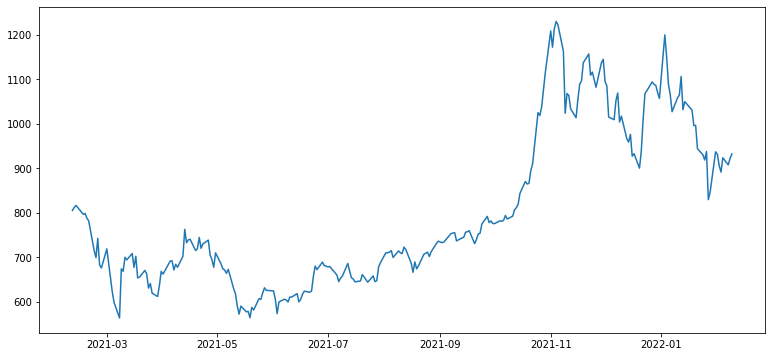

In [129]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [130]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Series([], Name: Close, dtype: float64)


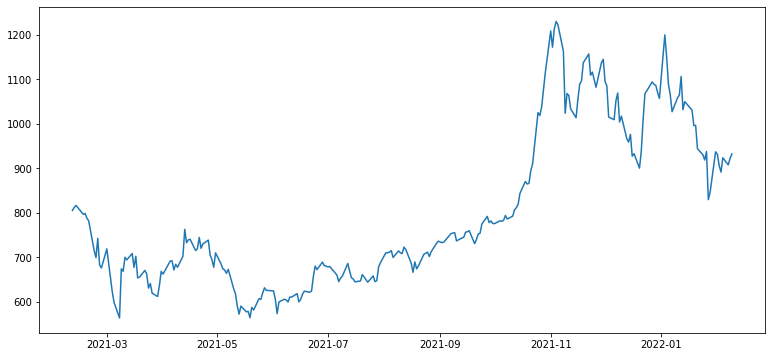

In [131]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

In [132]:
# 로그 변환
ts_log = np.log(ts)

In [133]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


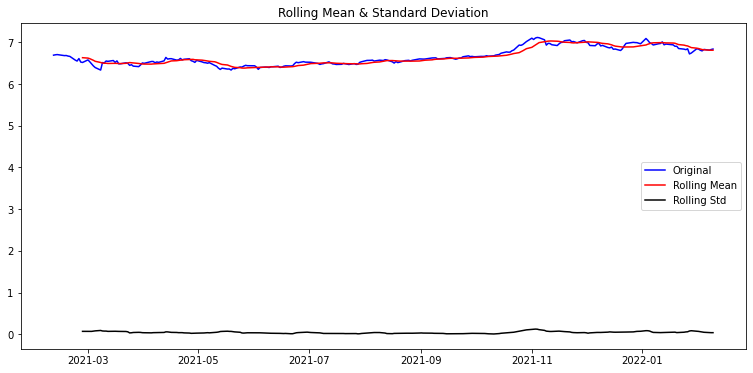

In [134]:
plot_rolling_statistics(ts_log, window=12)

In [135]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [136]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


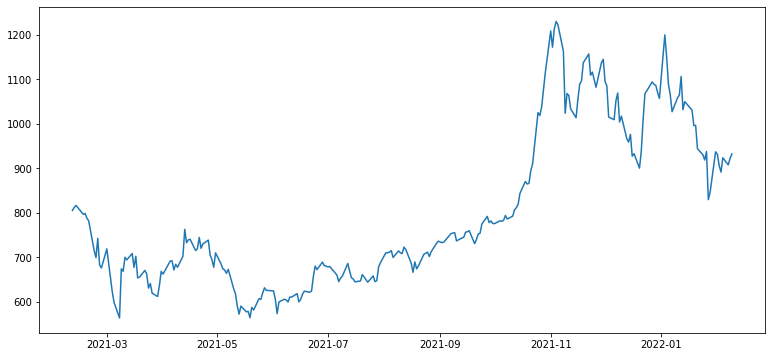

In [137]:
# 로그함수 변환
ts_log = np.log(ts)
plt.plot(ts)

In [138]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


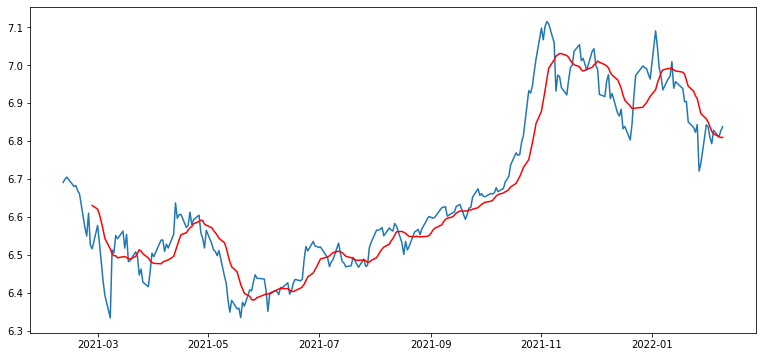

In [139]:
# Moving average 제거 : 추세(Trend) 상쇄

moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [140]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2021-02-10         NaN
2021-02-11         NaN
2021-02-12         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26   -0.114321
2021-03-01   -0.043243
2021-03-02   -0.074829
2021-03-03   -0.105908
Name: Close, dtype: float64

In [141]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-02-26   -0.114321
2021-03-01   -0.043243
2021-03-02   -0.074829
2021-03-03   -0.105908
2021-03-04   -0.135099
2021-03-05   -0.149566
2021-03-08   -0.181841
2021-03-09    0.009849
2021-03-10    0.007221
2021-03-11    0.053261
2021-03-12    0.050443
2021-03-15    0.067636
2021-03-16    0.022600
2021-03-17    0.060719
2021-03-18   -0.006980
Name: Close, dtype: float64

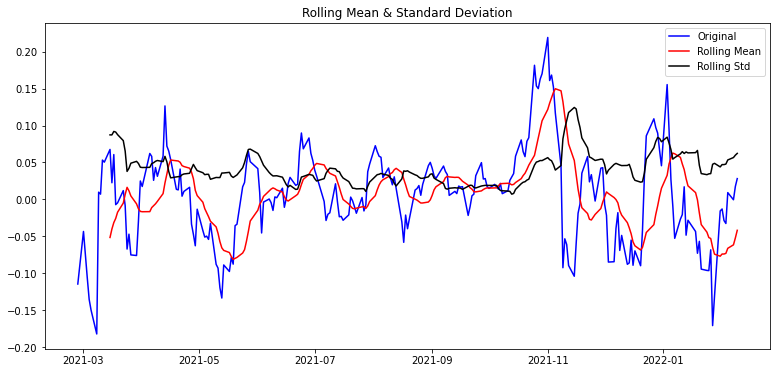

In [142]:
# 앞 단계에서 정의했던 메서드들을 활용하여 ts_log_moving_log를 정성, 정량적으로 분석
plot_rolling_statistics(ts_log_moving_avg)

In [143]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.581959
p-value                          0.006115
#Lags Used                      12.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


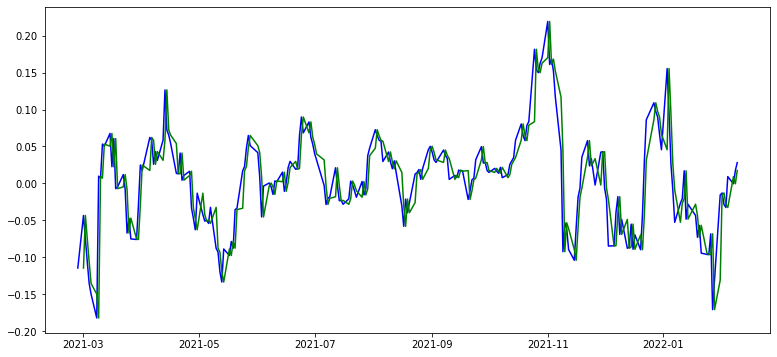

In [144]:
# Shift된 시계열과 원본 시계열에 대한 비교 그래프 작성
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

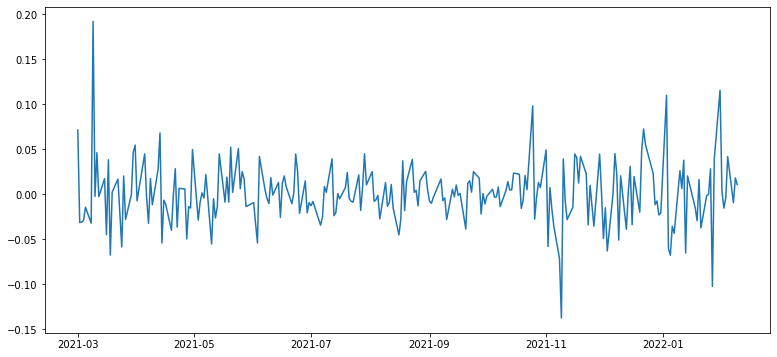

In [145]:
# 원본 시계열에서 Shift한 시계열을 뺸 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

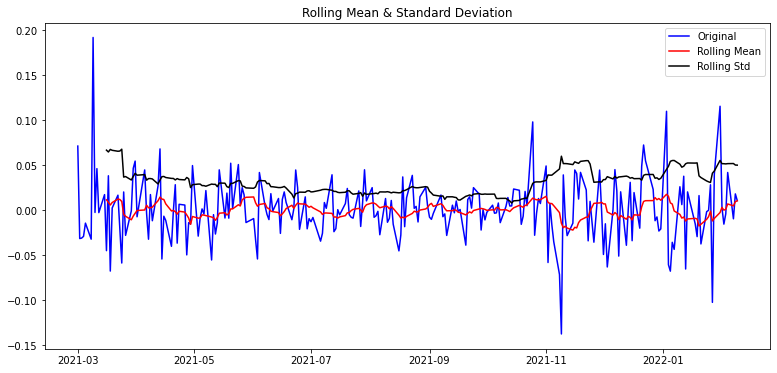

In [146]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 확인
plot_rolling_statistics(ts_log_moving_avg_diff)

In [147]:
# 차분의 효과를 확인하기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.477005e+00
p-value                        1.323498e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


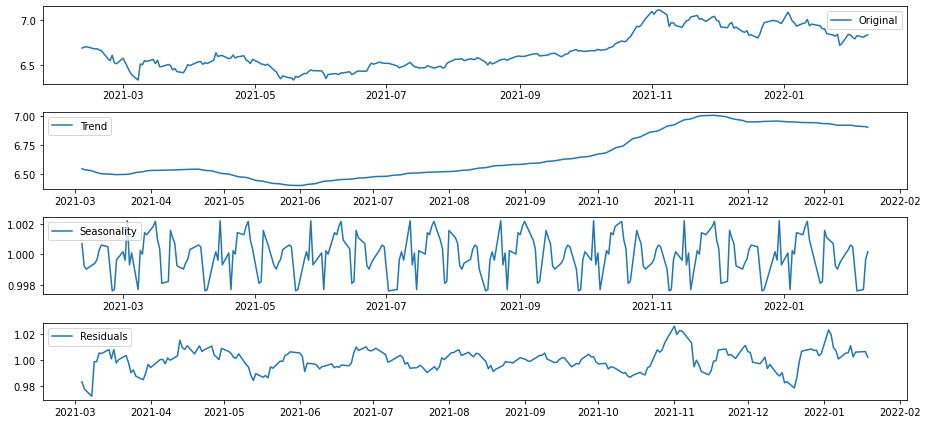

In [148]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

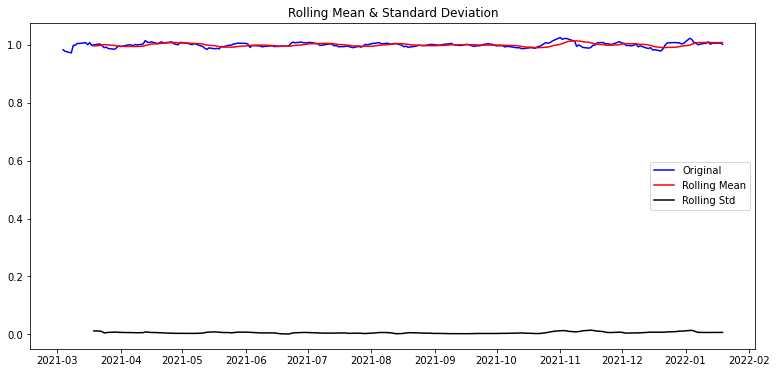

In [149]:
# Residual 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [150]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.951004e+00
p-value                        2.147324e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


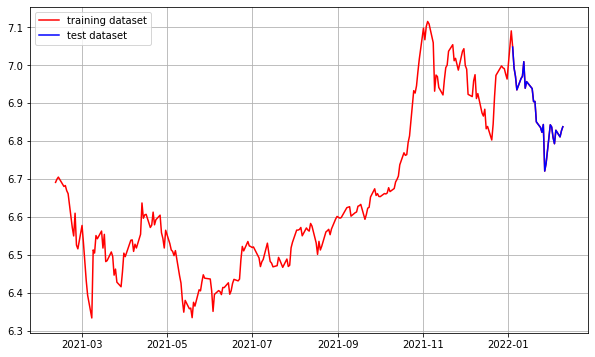

In [151]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

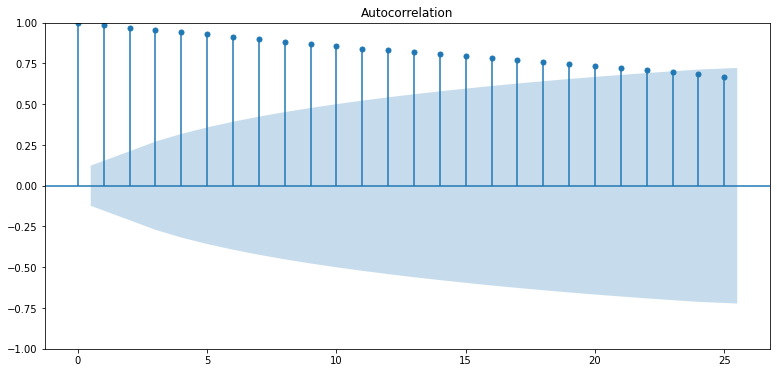

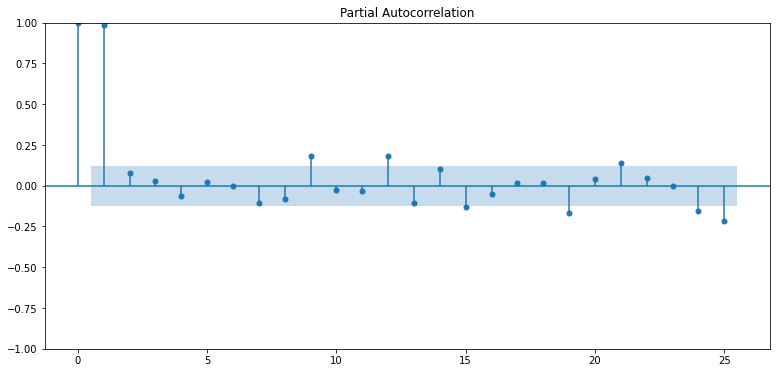

In [152]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


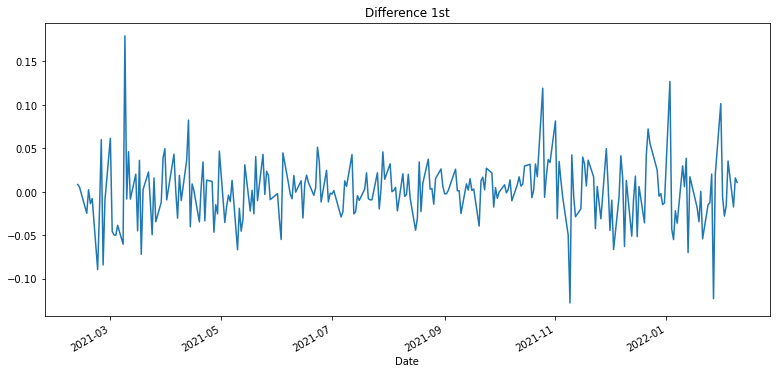

In [153]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


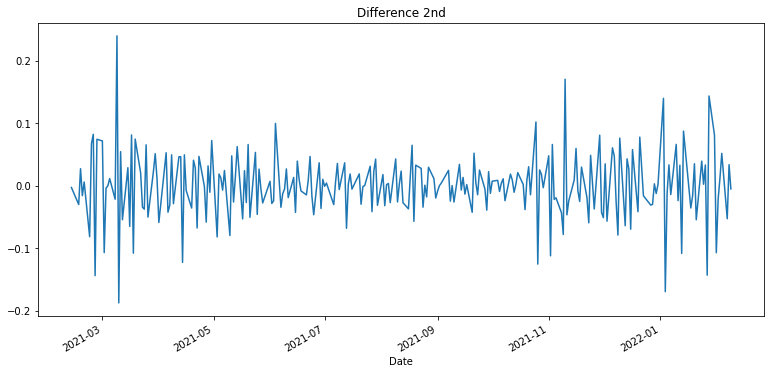

In [154]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [155]:
# 데이터셋의 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    6.690619
2021-02-11    6.699081
Name: Close, dtype: float64
(227,)
(26,)


In [195]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(25, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(25, 0, 0)   Log Likelihood                 459.586
Date:                Thu, 10 Feb 2022   AIC                           -865.171
Time:                        11:22:57   BIC                           -772.698
Sample:                             0   HQIC                          -827.857
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7191      0.379     17.734      0.000       5.977       7.462
ar.L1          0.9613      0.072     13.372      0.000       0.820       1.102
ar.L2          0.0928      0.100      0.930      0.3

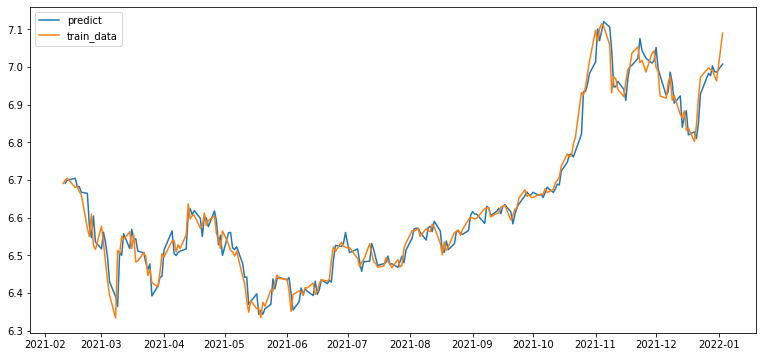

In [196]:
# ARIMA 모델 훈련 결과 시각화
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

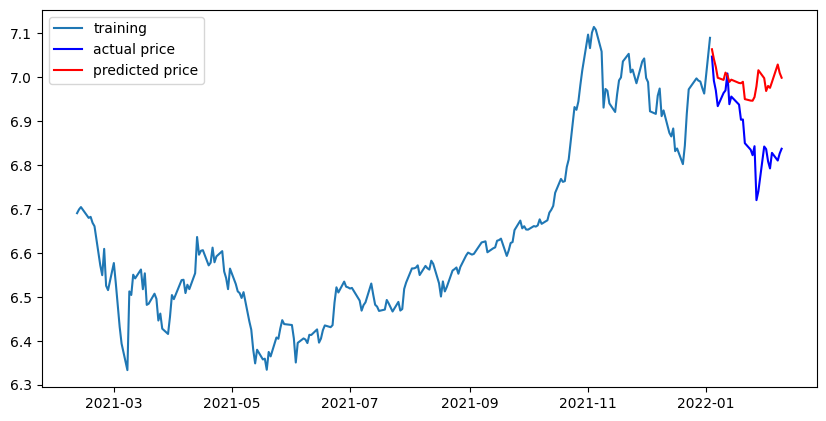

In [197]:
# Forecast : 결과가 fc에 담깁니다. 
model = ARIMA(train_data, order=(25, 0, 0))  
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [198]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17617.771162112836
MAE:  112.75148363669649
RMSE:  132.73195230280024
MAPE: 12.17%


## 회고
* 수학적인 지식이 많이 부족한 입장이어서 이론적인 내용을 공부하였을 시에는 어떤 방식으로 대입을 해야 하는지 이해가 되지 않아서 실습하면서도 상당히 애를 먹었다. 그러나 계속 코드를 보다 보니 어느 부분에 값을 대입해야 하는지와 대략적인 흐름에 대해서 조금은 이해할 수 있게 되었다.
* 특히 차분을 구하는 부분에서 출력된 값이 안정적인 값인지에 대한 판단이 어려웠다. 구글링을 통해 자료를 찾아 보니 차분을 구할 때 2차 이상으로 구해야 하는 경우는 거의 없다는 것을 알게 되었는데, 차분의 값이 얼마 정도가 되어야 안정적인지에 대한 기준을 알지 못해서 
* ARIMA 모델에 p, d, q 값을 대입할 때, 관련된 이론에 대한 이해가 부족했던 탓인지 적당한 모수값의 기준을 정하기 어려웠다. 결국 그래프를 보고 임의로 판단하여 값을 대입하였다. 짧은 시도에 끝나게 된다면 다행이지만, 이러한 작업이 오래 걸린다면 상당히 비효율적인 방식이 되지 않을까 하는 생각이 들었다.

## 참고 링크
* [Forecasting: Principles and Practice](https://otexts.com/fppkr/)